This notebook presents a part of my code for the Plant Pathology 2021 - FGVC8 Kaggle challenge. 

It shows how I trained the Vision Transformer model thanks to TensorFlow and Keras, on TPU hardware.  

The code is very similar to the ResNet50 training, explained in details in the corresponding notebook. Thus for more detailed explanations and some exploratory data analysis, refer to the [**ResNet50 training notebook**](https://github.com/antonindurieux/Plant_Pathology_2021-FGVC8_Kaggle_challenge/blob/master/1_plant-pathology-2021-fgvc8-resnet50-training.ipynb).

Other parts of the code can be found here :
- [**ResNet50 model training**](https://github.com/antonindurieux/Plant_Pathology_2021-FGVC8_Kaggle_challenge/blob/master/1_plant-pathology-2021-fgvc8-resnet50-training.ipynb) ;
- [**EfficientNetB7 model training**](https://github.com/antonindurieux/Plant_Pathology_2021-FGVC8_Kaggle_challenge/blob/master/2_plant-pathology-2021-fgvc8-effnetb7-training.ipynb) ;
- [**Inference on the test data**](https://github.com/antonindurieux/Plant_Pathology_2021-FGVC8_Kaggle_challenge/blob/master/4_plant-pathology-2021-fgvc8-inference.ipynb).

An article about this project can be found on my website [**here**](https://antonindurieux.github.io/portfolio/1_Kaggle_Plant_Pathology_2021_competition/).

## 1. What is a Vision Transformer ?

Vision Transformers (ViT) are relatively new and less well-established than Convolutional Neural Networks nowadays. Nonetheless, they are becoming frequently used in Kaggle competitions and can perform very well, achieving comparable and sometimes better results than the more usual CNN models.  
Vision Transformers are deriving from [transformers model](https://en.wikipedia.org/wiki/Transformer_(machine_learning_model)) used in NLP, which are designed to handle sequential input data and work based on the attention mechanism. But how does it work with images ?  

1. The image is divided into a grid of square patches ;
2. The patches are flatten into single vectors ;
3. These vectors are projected to lower dimension ;
4. Position embeddings are learned for each patch ;
5. The sequence is fed to a Transformer Encoder ;
6. The output of the transformer is fed into a classification layer.  

![](/assets/ViT_diagram.gif)

Vision Transformers require a huge amount of data to be trained, but they can then be fine-tuned to the task at hand. The best way to easily use a ViT is thus to load pre-trained weights and to launch a few more training iteration on your dataset, with an adapted dense layer for the output.  

Here is a list of interesting references I found about Vision Transformers :
- The original article introducing Vision Transformers : ["An Image is Worth 16x16 Words: Transformers for Image Recognition at Scale"](https://arxiv.org/abs/2010.11929) ;
- A short article explaining Vision Transformers on the Google AI Blog : ["
Transformers for Image Recognition at Scale "](https://ai.googleblog.com/2020/12/transformers-for-image-recognition-at.html) ;
- A nice blog post explaining Vision Transformers and showing an implementation with PyTorch : ["How the Vision Transformer (ViT) works in 10 minutes: an image is worth 16x16 words"](https://theaisummer.com/vision-transformer/).

## 2. Imports and configuration

We start by importing the required packages and configure the TPUs.  
I used the ViT implementation of [**this package**](https://pypi.org/project/vit-keras/) which worked pretty well.

In [1]:
!pip install --quiet vit-keras

In [2]:
# Imports
import os
import pandas as pd
import numpy as np
import seaborn as sns
from matplotlib import pyplot as plt
import plotly.graph_objects as go
from kaggle_datasets import KaggleDatasets

from sklearn.preprocessing import MultiLabelBinarizer
from sklearn.model_selection import train_test_split

import tensorflow as tf
from tensorflow.keras.layers import Flatten, Dense
import tensorflow_addons as tfa

from vit_keras import vit

sns.set()

In [3]:
try:
    # TPU detection
    tpu = tf.distribute.cluster_resolver.TPUClusterResolver()
    print("Running on TPU ", tpu.cluster_spec().as_dict()["worker"])
    # Connection to TPU
    tf.config.experimental_connect_to_cluster(tpu)
    # Initialization of the TPU devices
    tf.tpu.experimental.initialize_tpu_system(tpu)
    # Create a state & distribution policy on the TPU devices
    strategy = tf.distribute.experimental.TPUStrategy(tpu)

except ValueError:
    print("Not connected to a TPU runtime. Using CPU/GPU strategy")
    strategy = tf.distribute.MirroredStrategy()

Running on TPU  ['10.0.0.2:8470']


In [4]:
BATCH_SIZE = 16 * strategy.num_replicas_in_sync

print("Number of replicas : ", strategy.num_replicas_in_sync)
print("Batch size : ", BATCH_SIZE)

Number of replicas :  8
Batch size :  128


## 3. Data import and dataset generation


Now we load the labels and build TensorFlow datasets to efficiently load the data during training steps :

In [5]:
# Labels import as a DataFrame
train_label_csv = "../input/plant-pathology-2021-fgvc8/train.csv"
train_label_df = pd.read_csv(train_label_csv)

In [6]:
# Get GCS bucket path
gcs_ds_path = KaggleDatasets().get_gcs_path("plant-pathology-2021-fgvc8")

# Get the images paths
train_images_path = gcs_ds_path + "/train_images/"
files_ls = tf.io.gfile.glob(train_images_path + '*.jpg')

In [7]:
# Labels one-hot-encoding
mlb = MultiLabelBinarizer()

train_label_df["labels_list"] = train_label_df.labels.apply(
    lambda x: x.split(' '))

df_class_dummies = pd.DataFrame(mlb.fit_transform(
    train_label_df.labels_list), columns=mlb.classes_, index=train_label_df.index)
train_label_df = pd.concat(
    [train_label_df[["image", "labels"]], df_class_dummies], axis=1)

# One-hot-encoded labels
pathologies = mlb.classes_
labels = train_label_df[pathologies]

In [8]:
IMG_HEIGHT_RESIZE = 700
IMG_WIDTH_RESIZE = 700
IMG_HEIGHT = 608
IMG_WIDTH = 608

# Autotuned data prefetching
AUTO = tf.data.experimental.AUTOTUNE


def crop_center(image):
    """
    Crop an image to its central square
    """
    h, w = tf.shape(image)[-3], tf.shape(image)[-2]
    if h > w:
        cropped_image = tf.image.crop_to_bounding_box(
            image, (h - w) // 2, 0, w, w)
    else:
        cropped_image = tf.image.crop_to_bounding_box(
            image, 0, (w - h) // 2, h, h)
    return cropped_image


def data_augment(image, label):
    """
    Apply data augmentation to images
    """
    image = tf.image.random_brightness(image, 0.3)
    image = tf.image.random_contrast(image, 1, 3)
    image = tf.image.random_saturation(image, 1, 1.3)
    image = tf.image.random_flip_left_right(image)
    image = tf.image.random_flip_up_down(image)
    image = tf.image.random_crop(image, [IMG_HEIGHT, IMG_WIDTH, 3])
    return image, label


def process_img(filepath, label):
    """
    Read an image from its filepath, crop it to its central square and resize it
    """
    image = tf.io.read_file(filepath)
    image = tf.image.decode_jpeg(image, channels=3)
    image = tf.image.convert_image_dtype(image, tf.float32)
    image = crop_center(image)
    image = tf.image.resize(image, [IMG_HEIGHT_RESIZE, IMG_WIDTH_RESIZE])

    return image, label


def get_training_dataset(filenames, labels, do_aug=True):
    """
    Create the training dataset
    """
    dataset = tf.data.Dataset.from_tensor_slices((filenames, labels))
    dataset = dataset.map(process_img, num_parallel_calls=AUTO)
    dataset = dataset.cache()  # Cache the dataset in memory at first iteration
    if do_aug:
        dataset = dataset.map(data_augment, num_parallel_calls=AUTO)
    dataset = dataset.shuffle(2048)
    dataset = dataset.batch(BATCH_SIZE)
    dataset = dataset.repeat()
    dataset = dataset.prefetch(AUTO)
    return dataset


def resize_validation_dataset(image, label):
    """
    Resize the validation dataset images to the same dimensions as the training dataset
    """
    image = tf.image.resize(image, [IMG_HEIGHT, IMG_WIDTH])
    return image, label


def get_validation_dataset(filenames, labels):
    """
    Create the validation dataset
    """
    dataset = tf.data.Dataset.from_tensor_slices((filenames, labels))
    dataset = dataset.map(process_img, num_parallel_calls=AUTO)
    dataset = dataset.map(resize_validation_dataset, num_parallel_calls=AUTO)
    dataset = dataset.batch(BATCH_SIZE)
    dataset = dataset.cache()  # Cache the dataset in memory at first iteration
    dataset = dataset.prefetch(AUTO)
    return dataset

In [9]:
train_files, val_files, train_labels, val_labels = train_test_split(
    files_ls, labels, test_size=0.1, random_state=123)

ds_train = get_training_dataset(train_files, train_labels)
ds_val = get_validation_dataset(val_files, val_labels)

## 4. Training of the Vision Transformer model

We load the ViT model with pretrained weights then fine-tune it on our data. 

In [10]:
n_labels = len(pathologies)

IMG_SHAPE = (IMG_HEIGHT, IMG_WIDTH) + (3,)

with strategy.scope():
    base_model = vit.vit_b16(
        image_size = IMG_HEIGHT,
        activation = 'sigmoid',
        pretrained = True,
        include_top = False,
        pretrained_top = False,
        classes = n_labels)

347504640/347502902 [==============================] - 6s 0us/step


/opt/conda/lib/python3.7/site-packages/vit_keras/utils.py:79: UserWarning: Resizing position embeddings from 24 to 38
  UserWarning,


In [11]:
base_model.trainable = True

with strategy.scope():
    inputs = tf.keras.Input(shape=IMG_SHAPE)
    x = base_model(inputs, training=True)
    x = Flatten()(x)

    outputs = Dense(n_labels, activation='sigmoid')(x)

    model = tf.keras.Model(inputs, outputs)

model.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 608, 608, 3)]     0         
_________________________________________________________________
vit-b16 (Functional)         (None, 768)               86757120  
_________________________________________________________________
flatten (Flatten)            (None, 768)               0         
_________________________________________________________________
dense (Dense)                (None, 6)                 4614      
Total params: 86,761,734
Trainable params: 86,761,734
Non-trainable params: 0
_________________________________________________________________


In [12]:
# from https://towardsdatascience.com/the-unknown-benefits-of-using-a-soft-f1-loss-in-classification-systems-753902c0105d
def macro_soft_f1(y, y_hat):
    """
    Compute the macro soft F1-score as a cost.
    Average (1 - soft-F1) across all labels.
    Use probability values instead of binary predictions.

    Args:
        y (int32 Tensor): targets array of shape (BATCH_SIZE, N_LABELS)
        y_hat (float32 Tensor): probability matrix of shape (BATCH_SIZE, N_LABELS)

    Returns:
        cost (scalar Tensor): value of the cost function for the batch
    """

    y = tf.cast(y, tf.float32)
    y_hat = tf.cast(y_hat, tf.float32)
    tp = tf.reduce_sum(y_hat * y, axis=0)
    fp = tf.reduce_sum(y_hat * (1 - y), axis=0)
    fn = tf.reduce_sum((1 - y_hat) * y, axis=0)
    soft_f1 = 2*tp / (2*tp + fn + fp + 1e-16)
    cost = 1 - soft_f1  # reduce 1 - soft-f1 in order to increase soft-f1
    macro_cost = tf.reduce_mean(cost)  # average on all labels

    return macro_cost

In [13]:
base_learning_rate = 0.00005

with strategy.scope():
    model.compile(optimizer=tf.keras.optimizers.Adam(lr=base_learning_rate), 
                  loss=macro_soft_f1,
                  metrics=[tfa.metrics.F1Score(num_classes=n_labels, average="macro", threshold=0.5, name="f1_score")])

In [14]:
epochs = 30

rlp = tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss', patience=2, verbose=1, factor=0.2)
es = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=3, verbose=1, restore_best_weights=True)

history = model.fit(ds_train, 
                    validation_data=ds_val, 
                    epochs=epochs, 
                    callbacks=[rlp, es],
                    steps_per_epoch=len(train_files)//BATCH_SIZE,
                    validation_steps=len(val_files)//BATCH_SIZE)

Epoch 1/30
131/131 [==============================] - 1042s 6s/step - loss: 0.4425 - f1_score: 0.6048 - val_loss: 0.2316 - val_f1_score: 0.8645
Epoch 2/30
131/131 [==============================] - 207s 2s/step - loss: 0.2430 - f1_score: 0.8715 - val_loss: 0.2239 - val_f1_score: 0.8733
Epoch 3/30
131/131 [==============================] - 207s 2s/step - loss: 0.2226 - f1_score: 0.8847 - val_loss: 0.2128 - val_f1_score: 0.8864
Epoch 4/30
131/131 [==============================] - 207s 2s/step - loss: 0.2186 - f1_score: 0.8910 - val_loss: 0.2289 - val_f1_score: 0.8546
Epoch 5/30
131/131 [==============================] - 207s 2s/step - loss: 0.2101 - f1_score: 0.8945 - val_loss: 0.2241 - val_f1_score: 0.8607

Epoch 00005: ReduceLROnPlateau reducing learning rate to 9.999999747378752e-06.
Epoch 6/30
131/131 [==============================] - 206s 2s/step - loss: 0.1995 - f1_score: 0.8989 - val_loss: 0.1997 - val_f1_score: 0.8965
Epoch 7/30
131/131 [==============================] - 207s 2

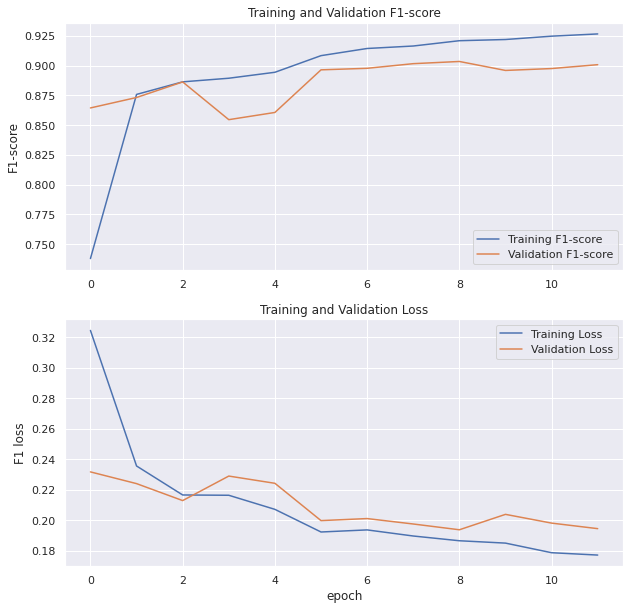

In [15]:
f1_score = history.history['f1_score']
val_f1_score = history.history['val_f1_score']

loss = history.history['loss']
val_loss = history.history['val_loss']

plt.figure(figsize=(10, 10))
plt.subplot(2, 1, 1)
plt.plot(f1_score, label='Training F1-score')
plt.plot(val_f1_score, label='Validation F1-score')
plt.legend(loc='lower right')
plt.ylabel('F1-score')
plt.title('Training and Validation F1-score')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.ylabel('F1 loss')
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.show()

We see that the training seems a bit erratic at first but the final results on the validation set are slightly better than with the ResNet and the EfficientNet models.

In [16]:
# Model saving
model_name = 'vit_model.h5'
model.save(model_name)

## 5. Results analysis


Now we can compare the label distribution with the ground truth, and check some examples were the model failed to correctly label the image :

In [17]:
# Predictions on the validation dataset
val_predictions = model.predict(ds_val, batch_size=BATCH_SIZE)

In [18]:
def format_predictions(preds, files, thresholds, fill_no_label=False, labels=pathologies, oh_labels=True):
    """
    Format predictions to get a DataFrame from the prediction matrix

    Args:
        preds (float32 numpy array): predictions matrix (N_IMAGES, N_LABELS)
        files (list): list of image files
        thresholds (list): list of prediction thresholds associated with each labels 
        fill_no_label (boolean): wether or not to fill empty predictions with argmax
        labels (list): list of labels names
        oh_labels (boolean): wether or not to get booleans associated with labels in the output DataFrame

    Returns:
        predictions_df (DataFrame): predictions DataFrame
    """

    preds_copy = preds.copy()

    # Handling no label cases
    if fill_no_label:
        for i in range(preds_copy.shape[0]):
            if np.all(preds_copy[i, :] < thresholds):
                preds_copy[i, np.argmax(preds_copy[i, :])] = 1

    # Apply thresholds to get boolean values
    for j in range(preds_copy.shape[1]):
        preds_copy[:, j] = np.where(preds_copy[:, j] < thresholds[j], 0, 1)

    # Reverse MultiLabelBinarizer
    mlb_predictions = mlb.inverse_transform(preds_copy)
    mlb_predictions = [' '.join(x) for x in mlb_predictions]

    # Create the output DataFrame
    predictions_series = pd.Series(mlb_predictions, name="labels")
    oh_predictions_df = pd.DataFrame(data=preds_copy, columns=labels)
    file_names = [x.split('/')[-1] for x in files]
    file_names_series = pd.Series(file_names, name="file_name")
    predictions_df = pd.concat([file_names_series, predictions_series], axis=1)

    # Get one-hot-labels in the output DataFrame
    if oh_labels:
        predictions_df = pd.concat([predictions_df, oh_predictions_df], axis=1)

    return predictions_df

In [19]:
val_predictions_df = format_predictions(
    val_predictions, val_files, thresholds=[0.5, 0.5, 0.5, 0.5, 0.5, 0.5])

In [20]:
val_predictions_df["labels"].value_counts()

scab                               486
healthy                            449
frog_eye_leaf_spot                 318
rust                               205
complex                            129
powdery_mildew                     128
complex frog_eye_leaf_spot          54
complex frog_eye_leaf_spot scab     39
complex rust                        18
frog_eye_leaf_spot scab             11
complex powdery_mildew              10
complex scab                         9
                                     7
powdery_mildew scab                  1
Name: labels, dtype: int64

In [21]:
ground_truth_df = format_predictions(val_labels.values, val_files, thresholds=[
                                     0.5, 0.5, 0.5, 0.5, 0.5, 0.5])

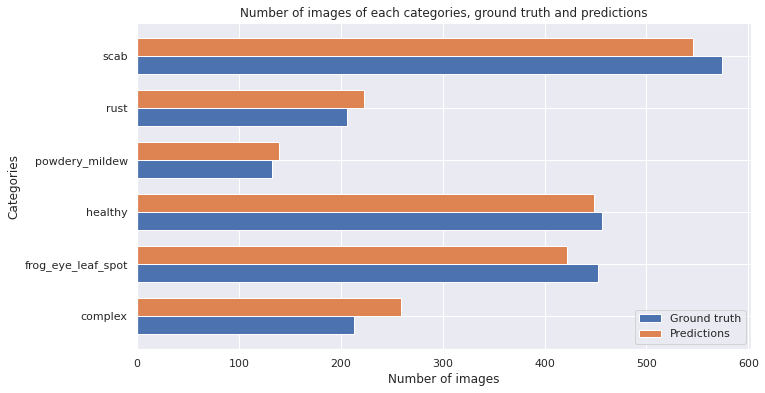

In [22]:
index = np.arange(len(pathologies))
bar_width = 0.35

fig, ax = plt.subplots(figsize=(11, 6))

ax.barh(index, ground_truth_df[pathologies].sum(),
        bar_width, label="Ground truth")
ax.barh(index+bar_width,
        val_predictions_df[pathologies].sum(), bar_width, label="Predictions")

ax.set_xlabel("Number of images")
ax.set_ylabel("Categories")
ax.set_title(
    "Number of images of each categories, ground truth and predictions")
ax.set_yticks(index + bar_width / 2)
ax.set_yticklabels(pathologies)

ax.legend()
plt.show()

In [23]:
# Compute a DataFrame of differences between the predictions and the ground truth
diff_ground_truth_pred_df = pd.concat([val_predictions_df["file_name"], ground_truth_df.compare(
    val_predictions_df, keep_shape=True)], axis=1)
diff_ground_truth_pred_df = ground_truth_df.compare(val_predictions_df)
diff_file_names = ground_truth_df.iloc[diff_ground_truth_pred_df.index]["file_name"]
diff_ground_truth_pred_df = diff_ground_truth_pred_df.join(
    diff_file_names).reset_index()

/opt/conda/lib/python3.7/site-packages/pandas/core/reshape/merge.py:648: UserWarning: merging between different levels can give an unintended result (2 levels on the left,1 on the right)
  warnings.warn(msg, UserWarning)


In [24]:
# Rate of images with at least one mislabeling
error_rate = len(diff_ground_truth_pred_df) / len(ground_truth_df) * 100
print("Error rate (images with at least one mislabeling) : {:.2f} %".format(
    error_rate))

Error rate (images with at least one mislabeling) : 12.55 %


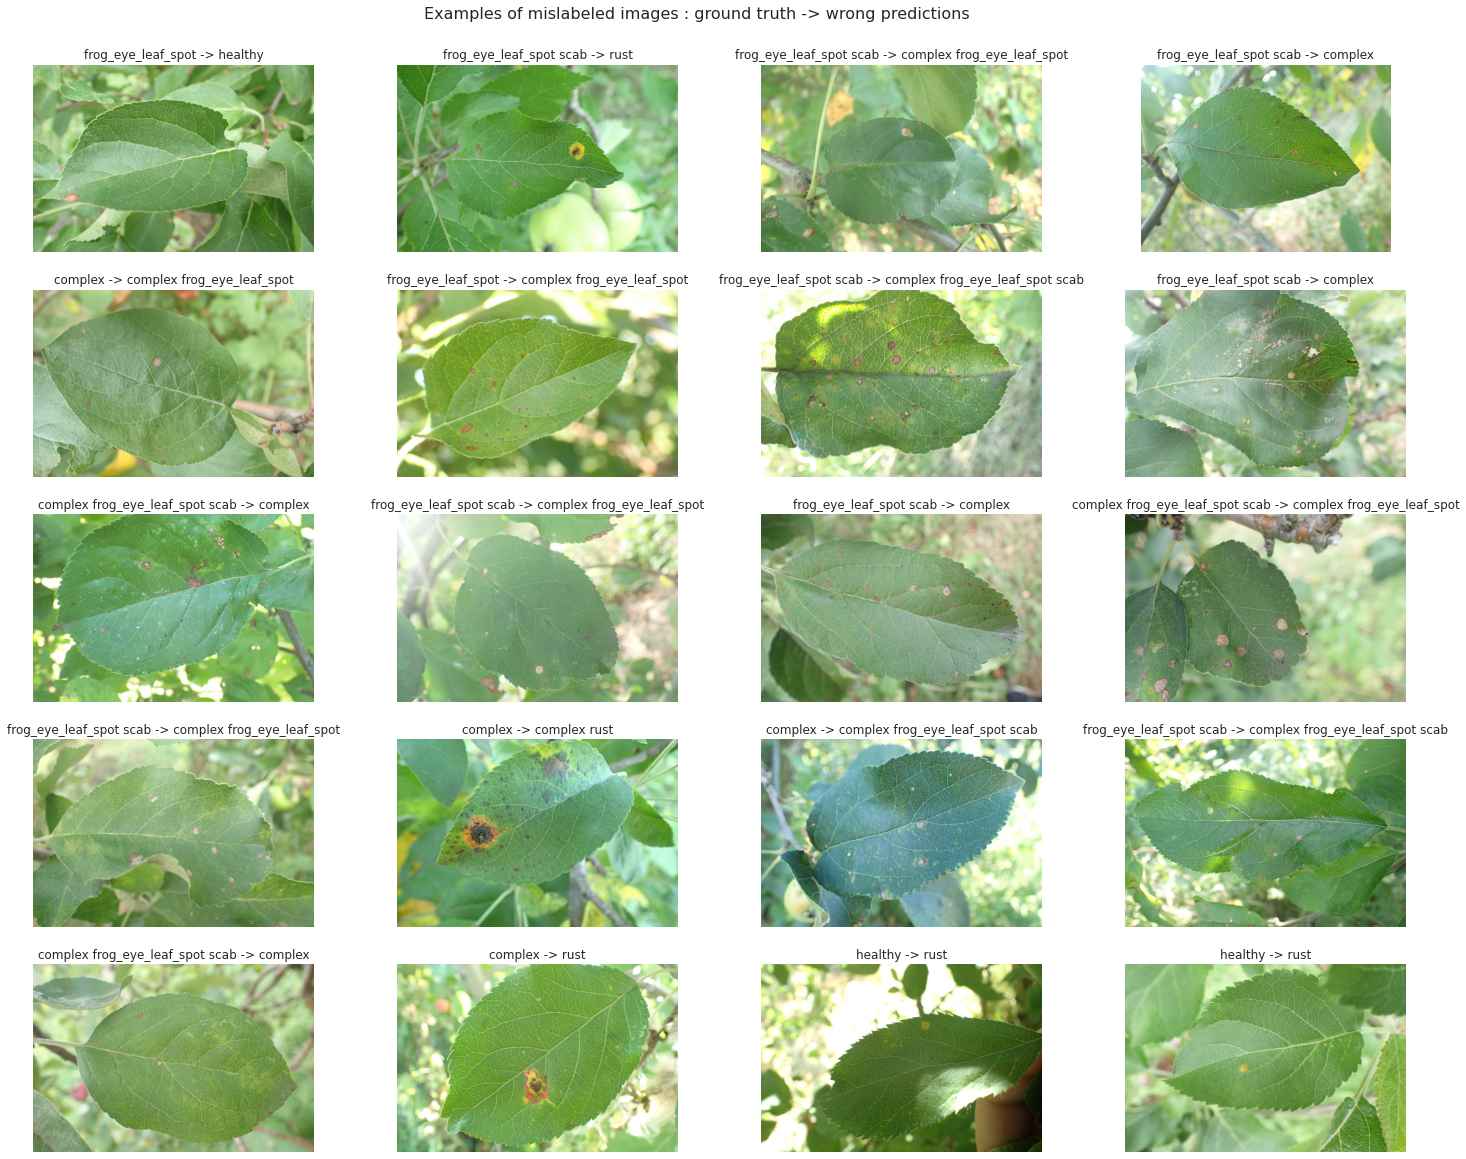

In [25]:
n_examples = 20
diff_examples_df = diff_ground_truth_pred_df.sample(
    frac=1).iloc[:n_examples].reset_index()

fig, ax = plt.subplots(n_examples // 4, 4, figsize=(25, n_examples))
plt_col = 0

for i, row in diff_examples_df.iterrows():
    plt_row = i//4
    img_name = row.file_name
    img_path = train_images_path + img_name
    img_file = tf.io.read_file(img_path)
    img = tf.image.decode_jpeg(img_file, channels=3)
    ax[plt_row, plt_col].imshow(img)
    ax[plt_row, plt_col].axis('off')
    ax[plt_row, plt_col].set_title(
        row[('labels', 'self')] + ' -> ' + row[('labels', 'other')])
    if plt_col == 3:
        plt_col = 0
    else:
        plt_col += 1

fig.suptitle(
    "Examples of mislabeled images : ground truth -> wrong predictions", fontsize=16, y=0.92)
plt.show()